# Analyzing the Venue, Weather, Daily Transaction Summary Dataset 
We want to see the connection between the weather and the order metrics. 

## Imports

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

In [ ]:
full_df = pd.read_csv('./datasets/venue_daily_weather.csv')

In [ ]:
totalorder = full_df[['venue_xref_id', 'payment_count']]
totalorder = totalorder.groupby('venue_xref_id').sum()

count = pd.DataFrame(full_df.groupby('venue_xref_id').size(), columns=['count'])
totalorder = pd.merge(totalorder, count, on='venue_xref_id', how = 'left')
totalorder['average'] = totalorder['payment_count']/totalorder['count']

df = pd.merge(full_df, totalorder, on='venue_xref_id', how ='left')
average_df = df

In [75]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92365 entries, 0 to 92364
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   venue_xref_id                   92365 non-null  object 
 1   business_date                   92365 non-null  object 
 2   bill_total_billed               92365 non-null  float64
 3   bill_total_discount_item_level  92365 non-null  float64
 4   bill_total_gratuity             92365 non-null  float64
 5   bill_total_net                  92365 non-null  float64
 6   bill_total_tax                  92365 non-null  float64
 7   bill_total_voided               92365 non-null  float64
 8   payment_amount                  92365 non-null  float64
 9   payment_count                   92365 non-null  int64  
 10  payment_total_tip               92365 non-null  float64
 11  sales_revenue_with_tax          92365 non-null  float64
 12  order_duration_seconds          

In [ ]:
# getting the sum of orders for each restaurant 
total_orders = full_df.groupby('venue_xref_id').agg(venue_order_total=('payment_count', 'sum'))

## Concept and Order Type Distributions

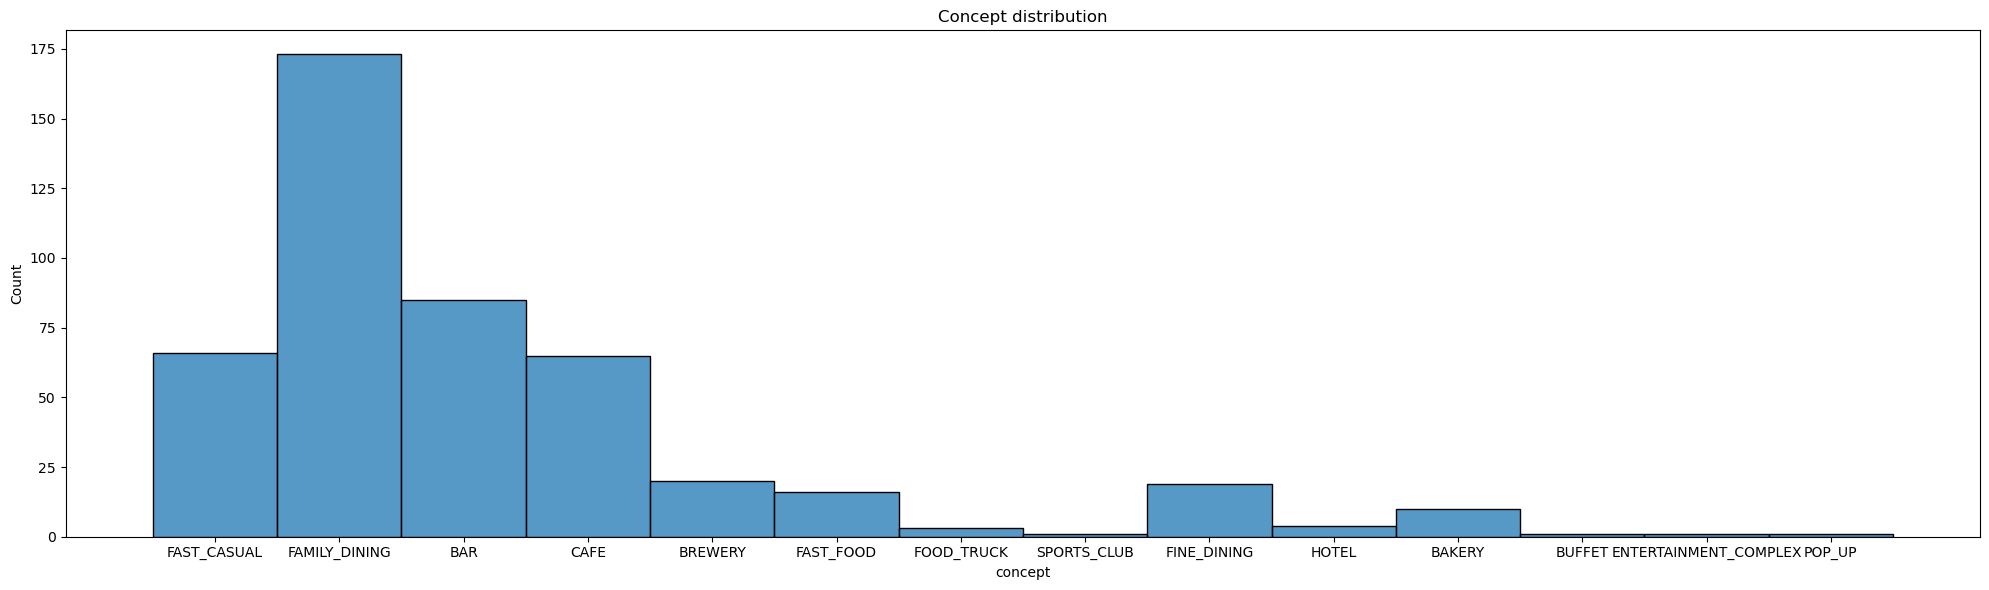

In [77]:
# distribution of concepts 
venue_concepts = full_df[['venue_xref_id', 'concept']].drop_duplicates()
plt.figure(figsize=(20, 6))
sns.histplot(venue_concepts['concept'])
plt.title('Concept distribution')
plt.tight_layout()
plt.show()

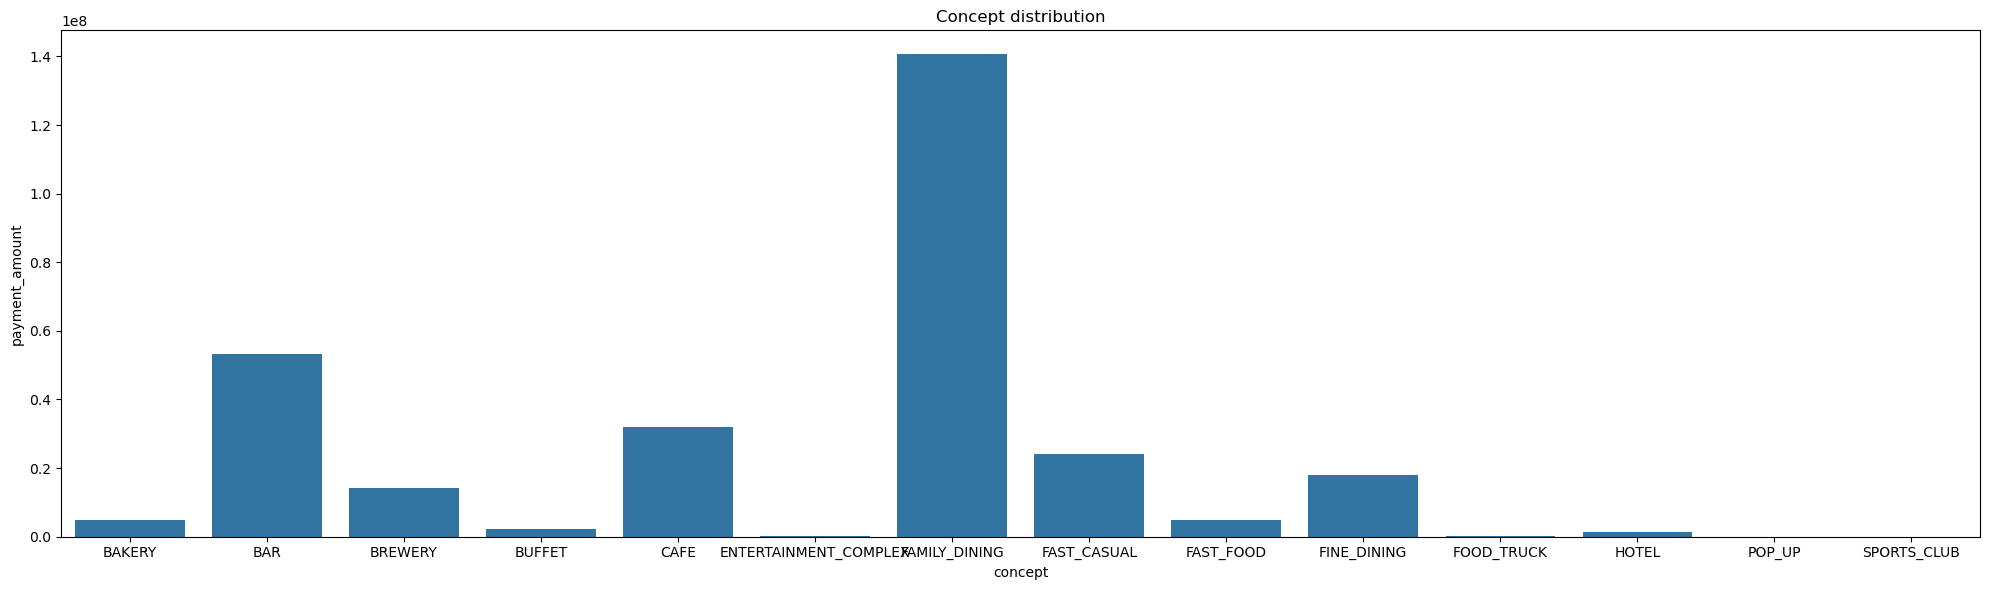

In [78]:
# Total payment amount by concept
df = full_df.groupby('concept')['payment_amount'].sum().reset_index()
plt.figure(figsize=(20, 6))
sns.barplot(x='concept', y='payment_amount', data=df)
plt.title('Payment amount for each concept')
plt.tight_layout()
plt.show()


In [79]:
# get the distribution of order types
sums = full_df[['dinein', 'bartab', 'takeout', 'delivery', 'onlineorder']].sum()
sum_df = pd.DataFrame({'total' : sums})
sum_df = sum_df.rename_axis('order_type')
plt.figure(figsize=(20, 6))
sns.barplot(x='order_type', y='total', data=sum_df)
plt.title('Concept distribution')
plt.tight_layout()
plt.show()

In [89]:
sums = full_df[['dinein', 'bartab', 'takeout', 'delivery', 'onlineorder']].sum()
sums

dinein         7443139
bartab          247617
takeout         975989
delivery         17849
onlineorder     270192
dtype: int64

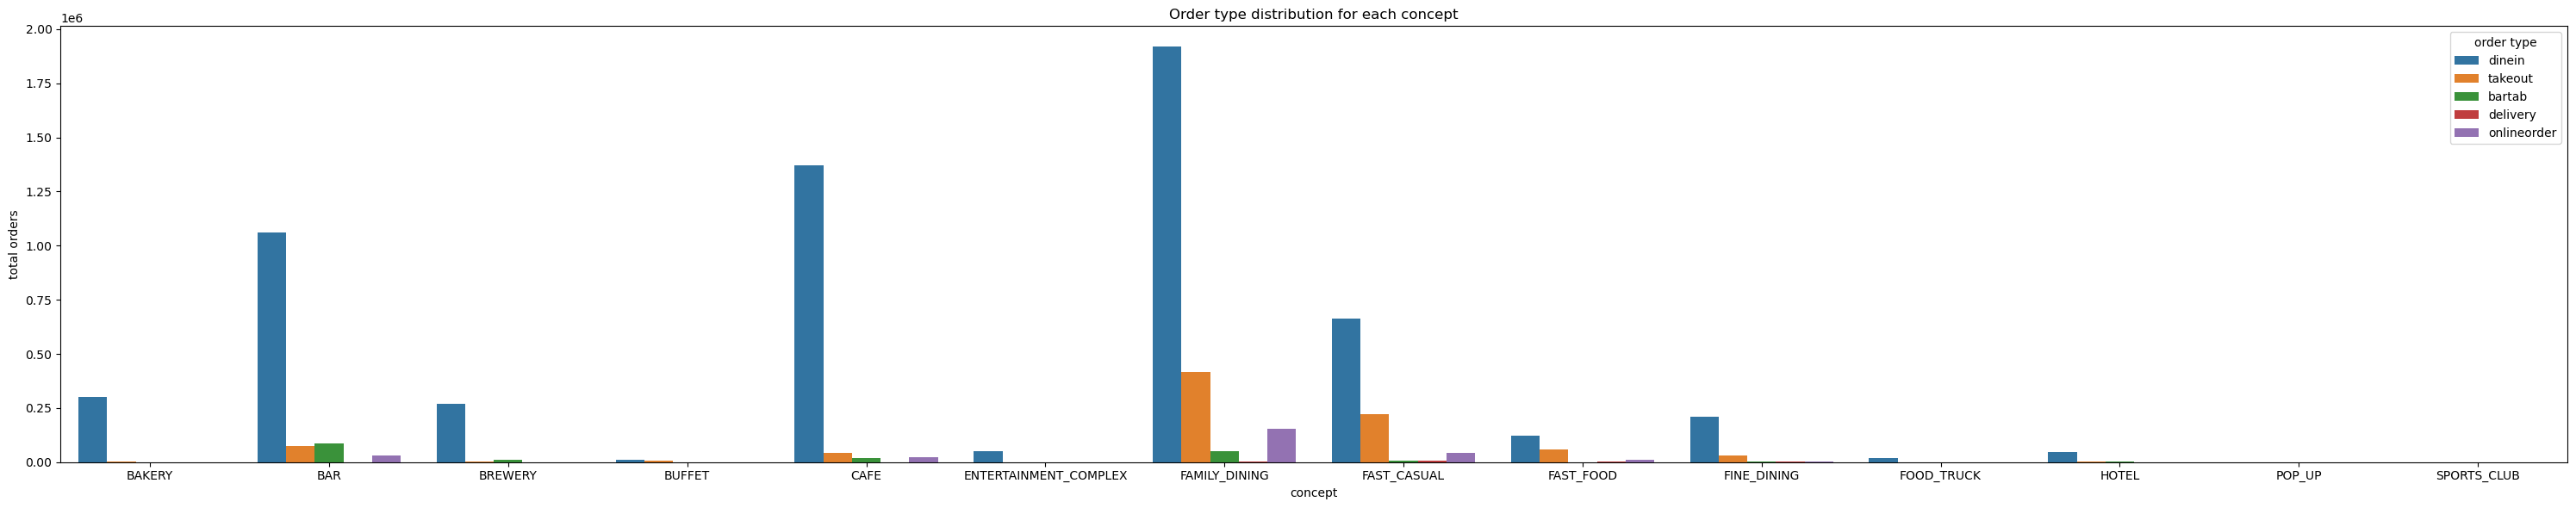

In [246]:
# order type distribution for each concept
df = full_df.groupby('concept')[['dinein', 'takeout', 'bartab', 'delivery', 'onlineorder']].sum().reset_index()
df_melted = df.melt(id_vars='concept', var_name='order type', value_name='total orders')

plt.figure(figsize=(30, 6))
sns.barplot(x='concept', y='total orders', hue='order type', data=df_melted)
plt.title('Order type distribution for each concept')
plt.tight_layout()
plt.show()


In [312]:
def getPercentageDataframe(category, concept=''):
    df = pd.merge(average_df, total_orders, on='venue_xref_id', how="left")
    df[f"{category}_percent"] = ((df[category] - df['average']) / df['average']) * 100
    if (concept): df = df[df['concept'] == concept]
    return df

Let's see how temperature affects the day's difference from it's average daily order. 

In [313]:
category = 'payment_count_x'
concept = '' # all concepts 
plt.figure(figsize=(10, 6))
sns.scatterplot(x='apparent_temperature_min', y=category + '_percent', data=getPercentageDataframe(category, concept))
plt.xlabel('Min Apparent Temperature Range(˚C)')
plt.ylabel(f'% Difference of average daily orders')
plt.ylim(-400,400)
plt.title(f'Min Apparent Temparature vs  {category} % Difference with average daily orders for {concept}')
plt.tight_layout()
plt.show()

## Weather trends 
We want to see if there are patterns between the weather data and the orders. You can change the col (ex. rain_sum, snowfall_sum, precipitation_sum) and category(order type) of the following cell to get a barplot. 

/var/folders/xf/bpwls17d4hqf_9glf_gn0ln80000gn/T/ipykernel_57787/2690949187.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[range_col] = pd.cut(df[col], bins=bins, labels=labels, right=False)
/var/folders/xf/bpwls17d4hqf_9glf_gn0ln80000gn/T/ipykernel_57787/2690949187.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  order_counts = df.groupby(range_col)[type].mean().reset_index()


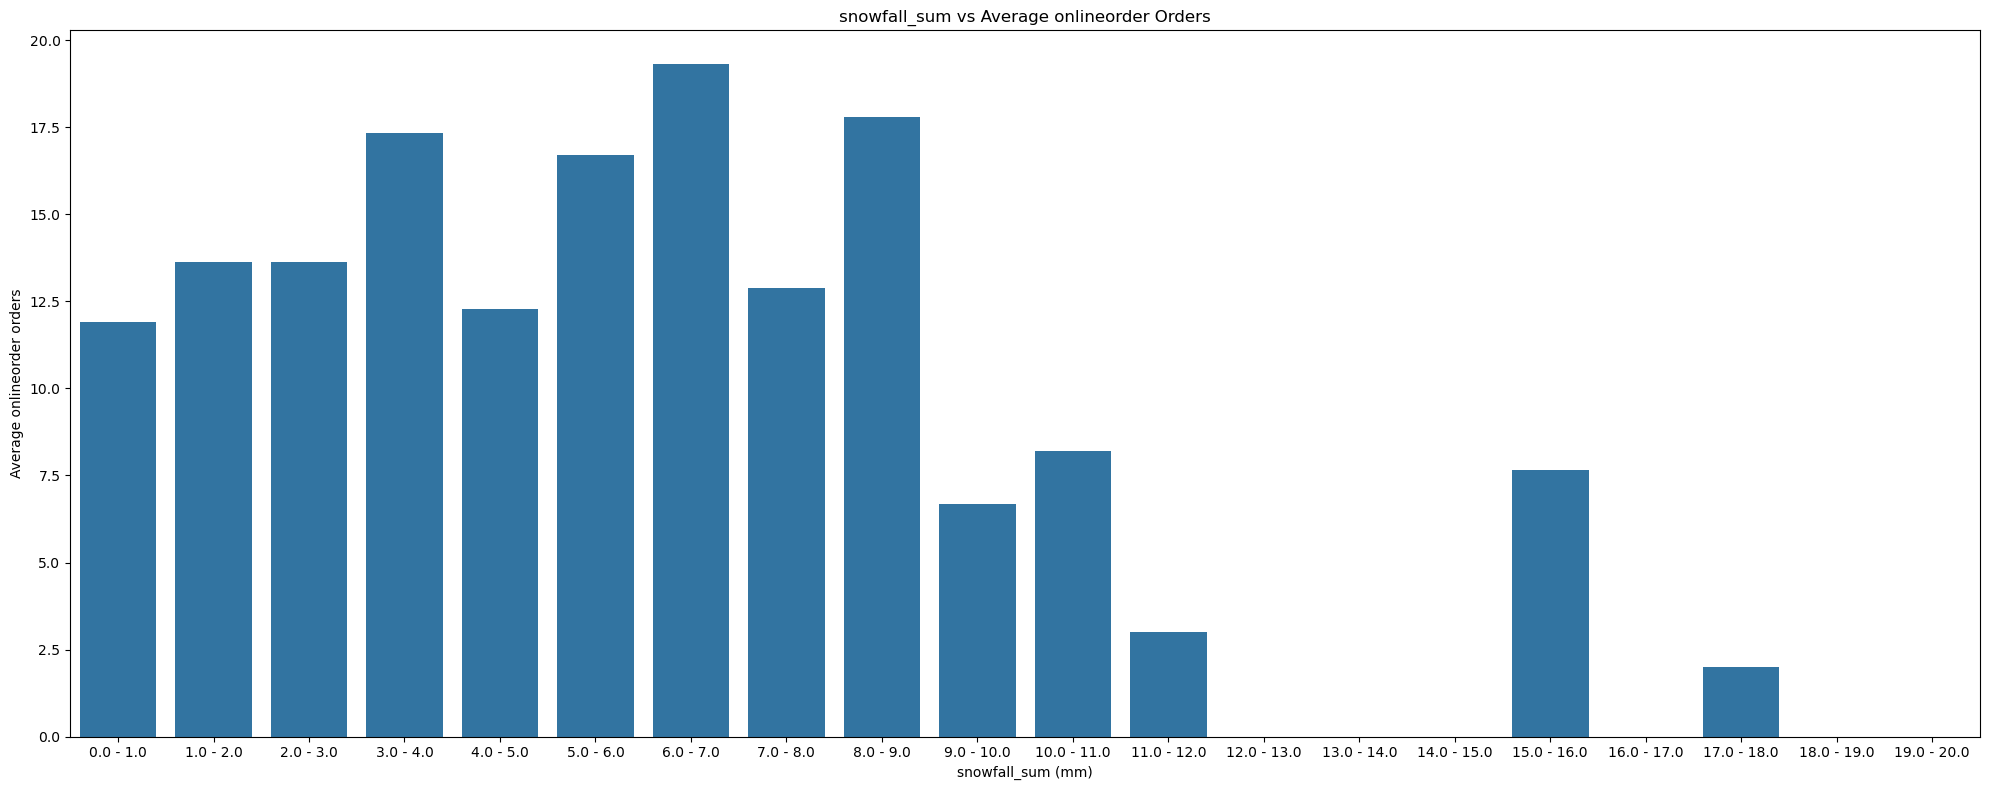

In [366]:
df = full_df
col = 'snowfall_sum'
range_col = col + '_range'
category = 'onlineorder'

grouped_type_sums = df.groupby('venue_xref_id')[category].sum()
positive_type = grouped_type_sums[grouped_type_sums > 0].index # exclude restaurants that never offer that type of order
df = df[df['venue_xref_id'].isin(positive_type)]


bins = np.linspace(0, 20, 21)
labels=[f'{bins[i]} - {bins[i+1]}' for i in range(len(bins) - 1)]
df[range_col] = pd.cut(df[col], bins=bins, labels=labels, right=False)

def getOrderMean(type):
    order_counts = df.groupby(range_col)[type].mean().reset_index()
    return order_counts

# plot for total orders based on snowfall
plt.figure(figsize=(20, 8))
sns.barplot(x=range_col, y=category, data=getOrderMean(category))
plt.xlabel(f'{col} (mm)')
plt.ylabel(f'Average {category} orders')
plt.title(f'{col} vs Average {category} Orders')
plt.tight_layout()
plt.show()